# DCGANs

### Carregando e preparando os dados

In [63]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
tf.__version__

'2.17.1'

In [64]:
(x_train, y_train), (_, _) = tf.keras.datasets.mnist.load_data()

In [65]:
x_train.shape, y_train.shape

((60000, 28, 28), (60000,))

7


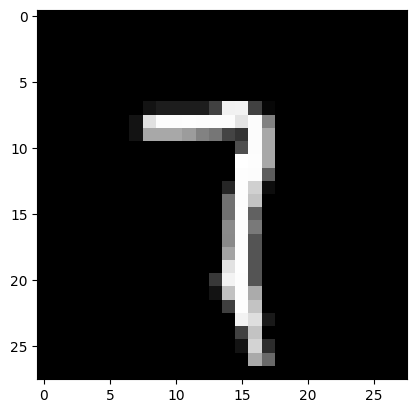

In [66]:
i = np.random.randint(0, 6000)
print(y_train[i])
plt.imshow(x_train[i], cmap = 'gray');

In [67]:
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1).astype('float32')
x_train.shape

(60000, 28, 28, 1)

In [68]:
x_train[0].min(), x_train[0].max()

(0.0, 255.0)

In [69]:
x_train = (x_train - 127.5) / 127.5

x_train[0].min(), x_train[0].max()

(-1.0, 1.0)

- Aqui indica que usaremos a função tangente hiperbólica, pois temos resultados entre -1 e 1

In [70]:
buffer_size = 60000
batch_size = 256

x_train = tf.data.Dataset.from_tensor_slices(x_train).shuffle(buffer_size).batch(batch_size)
print(type(x_train))

<class 'tensorflow.python.data.ops.batch_op._BatchDataset'>


# Gerador

In [71]:
from os import access
def generator():
  network = tf.keras.Sequential()
  network.add(layers.Dense(units = 7*7*256, use_bias = False, input_shape = (100, )))
  network.add(layers.BatchNormalization())
  network.add(layers.LeakyReLU())
  network.add(layers.Reshape((7, 7, 256)))
  #7x7128
  network.add(layers.Conv2DTranspose(filters = 128, kernel_size = (5, 5), padding = 'same', use_bias = False))
  network.add(layers.BatchNormalization())
  network.add(layers.LeakyReLU())
  #14x14x128
  network.add(layers.Conv2DTranspose(filters = 64, kernel_size = (5, 5), padding = 'same', use_bias = False, strides = (2,2)))
  network.add(layers.BatchNormalization())
  network.add(layers.LeakyReLU())
  #28x28x1
  network.add(layers.Conv2DTranspose(filters = 1, kernel_size = (5, 5), padding = 'same', use_bias = False, strides = (2, 2), activation = 'tanh'))
  network.summary()
  return network

In [72]:
gerador = generator()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                      │ (None, 12544)               │       1,254,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 12544)               │          50,176 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_10 (LeakyReLU)           │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_2 (Reshape)                  │ (None, 7, 7, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_6 (Conv2DTranspose) │ (None, 7, 7, 128)           │         819,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 7, 7, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_11 (LeakyReLU)           │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_7 (Conv2DTranspose) │ (None, 14, 14, 64)          │         204,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 14, 14, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_12 (LeakyReLU)           │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_8 (Conv2DTranspose) │ (None, 28, 28, 1)           │           1,600 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,330,944 (8.89 MB)

 Trainable params: 2,305,472 (8.79 MB)

 Non-trainable params: 25,472 (99.50 KB)

In [73]:
ruido = tf.random.normal([1, 100])
ruido

<tf.Tensor: shape=(1, 100), dtype=float32, numpy=
array([[ 1.8808838 , -0.50543207, -0.87382376,  0.08842396,  1.0604948 ,
         1.6631308 , -2.1933582 ,  0.9936063 , -0.28822008, -1.543908  ,
         1.1497052 , -0.649989  ,  0.977766  ,  0.7943377 ,  0.4604592 ,
         2.0356915 ,  0.26792535,  0.28124878,  0.01529802, -0.605931  ,
        -0.8114456 , -0.4820054 , -0.1181742 ,  0.28876722,  0.9746527 ,
         0.2494887 ,  0.62745774, -0.32768986, -0.9702191 ,  0.6119582 ,
         0.0312395 ,  0.9812524 ,  0.508599  , -0.8122217 ,  0.73173916,
         2.188317  ,  0.4204969 , -0.50791836,  0.22388013, -0.6204789 ,
        -1.1114955 ,  0.03621994,  0.2660639 ,  1.5675031 ,  0.8089927 ,
        -0.24498315, -0.93273   , -0.09192676, -0.7708248 ,  2.0603456 ,
        -0.2408237 , -0.14913057, -0.10231148,  0.54679865, -0.89809155,
         0.32063913, -0.40308273,  1.3035146 ,  1.3469634 ,  0.29392776,
        -1.0144832 ,  0.14518747, -0.82419086,  0.3725237 , -0.62738866,
 

In [74]:
imagem_gerada = gerador(ruido, training = False)
imagem_gerada.shape

TensorShape([1, 28, 28, 1])

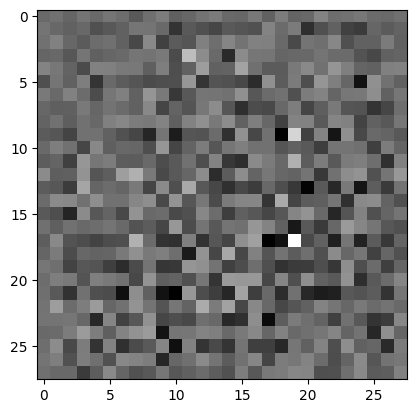

In [75]:
plt.imshow(imagem_gerada[0, :, :, 0], cmap = 'gray');

## Discriminador

In [76]:
def discriminator():
  network = tf.keras.Sequential()
  #14x14x64
  network.add(layers.Conv2D(filters = 64, strides = (2,2), kernel_size = (5,5), padding = 'same', input_shape = [28,28,1]))
  network.add(layers.LeakyReLU())
  network.add(layers.Dropout(0.3))
  #7x7x128
  network.add(layers.Conv2D(filters = 128, strides = (2,2), kernel_size = (5,5), padding = 'same'))
  network.add(layers.LeakyReLU())
  network.add(layers.Dropout(0.3))
  network.add(layers.Flatten())
  network.add(layers.Dense(1))
  network.summary()
  return network

In [77]:
discriminador = discriminator()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 14, 14, 64)          │           1,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_13 (LeakyReLU)           │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 7, 7, 128)           │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_14 (LeakyReLU)           │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │           6,273 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 212,865 (831.50 KB)

 Trainable params: 212,865 (831.50 KB)

 Non-trainable params: 0 (0.00 B)

In [78]:
discriminador(imagem_gerada, training = False)

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.00221853]], dtype=float32)>

## Loss Functions

In [79]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(expected_output, fake_output):
  real_loss = cross_entropy(tf.ones_like(expected_output), expected_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
  total_loss = real_loss + fake_loss
  return total_loss

def generator_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output), fake_output)

gerador_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminador_optimizer = tf.keras.optimizers.Adam(1e-4)

## Treinamento da DCGAN


In [80]:
epocas = 100
dimensao_ruido = 100
numero_imagens = 16

In [81]:
@tf.function
def train_step(imagens):
  ruido = tf.random.normal([batch_size, dimensao_ruido])
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    imagens_geradas = gerador(ruido, training = True)
    expected_output = discriminador(imagens, training = True)
    fake_output = discriminador(imagens_geradas, training = True)
    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(expected_output, fake_output)
    gradients_of_generator = gen_tape.gradient(gen_loss, gerador.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminador.trainable_variables)
    gerador_optimizer.apply_gradients(zip(gradients_of_generator, gerador.trainable_variables))
    discriminador_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminador.trainable_variables))

In [82]:
img_teste = tf.random.normal([numero_imagens, dimensao_ruido])
img_teste.shape

TensorShape([16, 100])

In [83]:
def gan_training(dataset, epocas, img_teste):
  for epoca in range(epocas):
    for imagem_batch in dataset:
      train_step(imagem_batch)
    print('Época: ', epoca + 1)
    imagens_geradas = gerador(img_teste, training = False)
    fig = plt.figure(figsize = (10, 10))
    for i in range(imagens_geradas.shape[0]):
      plt.subplot(4, 4, i + 1)
      plt.imshow(imagens_geradas[i, :, :, 0] * 127.5 + 127.5, cmap = 'gray')
      plt.axis('off')
    plt.show()

In [84]:
gan_training(x_train, epocas, img_teste)

Output hidden; open in https://colab.research.google.com to view.

#WGANs

In [87]:
import os
import time
from IPython import display

### Gerador
- Mesma estrutura da DCGAN

In [88]:
def wgan_generator():
  network = tf.keras.Sequential()
  network.add(layers.Dense(units = 7*7*256, use_bias = False, input_shape = (100, )))
  network.add(layers.BatchNormalization())
  network.add(layers.LeakyReLU())
  network.add(layers.Reshape((7, 7, 256)))
  #7x7128
  network.add(layers.Conv2DTranspose(filters = 128, kernel_size = (5, 5), padding = 'same', use_bias = False))
  network.add(layers.BatchNormalization())
  network.add(layers.LeakyReLU())
  #14x14x128
  network.add(layers.Conv2DTranspose(filters = 64, kernel_size = (5, 5), padding = 'same', use_bias = False, strides = (2,2)))
  network.add(layers.BatchNormalization())
  network.add(layers.LeakyReLU())
  #28x28x1
  network.add(layers.Conv2DTranspose(filters = 1, kernel_size = (5, 5), padding = 'same', use_bias = False, strides = (2, 2), activation = 'tanh'))
  network.summary()
  return network

In [89]:
wgan_gerador = wgan_generator()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                      │ (None, 12544)               │       1,254,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 12544)               │          50,176 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_15 (LeakyReLU)           │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_3 (Reshape)                  │ (None, 7, 7, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_9 (Conv2DTranspose) │ (None, 7, 7, 128)           │         819,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 7, 7, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_16 (LeakyReLU)           │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_10                  │ (None, 14, 14, 64)          │         204,800 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 14, 14, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_17 (LeakyReLU)           │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_11                  │ (None, 28, 28, 1)           │           1,600 │
│ (Conv2DTranspose)                    │                             │                 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,330,944 (8.89 MB)

 Trainable params: 2,305,472 (8.79 MB)

 Non-trainable params: 25,472 (99.50 KB)

In [90]:
ruido = tf.random.normal([1, 100])
print(ruido)

tf.Tensor(
[[ 0.60245144  1.3918328   0.2724392  -0.16223603  0.00350392 -0.4990814
  -0.652904    0.4147017   1.426074    1.4486336  -0.03468413 -1.7865005
   0.7383227   0.56298274  0.57432896  1.2369947  -0.07109861 -0.23805451
  -2.0264337   0.23843257 -0.6741016  -0.20684364 -0.19378278 -0.30929914
   1.2937233  -0.6483466   1.0269593   0.13329697 -1.53632    -1.1972276
   0.23043038  0.91514707  0.6519637  -0.7742997   1.2319518   0.10127942
  -1.5352534  -0.23512141  0.17147711  0.60935795  0.6141621  -0.617743
  -1.3664014  -0.12159786 -0.00473891 -1.3300227   0.1541867  -0.69067955
  -0.1728941  -0.06914429  0.4907427  -0.47553265 -0.5151506   1.0734191
  -1.0080186  -1.1347086   0.09553625 -0.47074237 -0.43523455  1.486269
   1.066632    1.6092614  -0.18747114  1.9454211  -1.902796   -0.18018214
   1.2004622   1.3952682   1.0633157  -0.6713764  -0.28224337  0.21068501
  -0.6463486  -2.1647637   0.13709144  0.83865523 -1.1208478  -1.0429641
   0.25662836 -0.8693221   1.0487262

(1, 28, 28, 1)


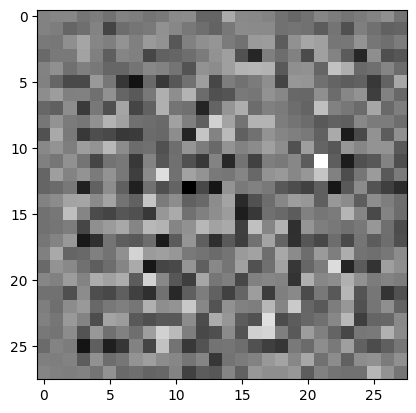

In [91]:
imagem_gerada = wgan_gerador(ruido, training = False)
print(imagem_gerada.shape)

plt.imshow(imagem_gerada[0, :, :, 0], cmap='gray')

### Critico
- Mesma estrutura do discriminador do DCGAN

In [92]:
def critic():
  network = tf.keras.Sequential()
  #14x14x64
  network.add(layers.Conv2D(filters = 64, strides = (2,2), kernel_size = (5,5), padding = 'same', input_shape = [28,28,1]))
  network.add(layers.LeakyReLU())
  network.add(layers.Dropout(0.3))
  #7x7x128
  network.add(layers.Conv2D(filters = 128, strides = (2,2), kernel_size = (5,5), padding = 'same'))
  network.add(layers.LeakyReLU())
  network.add(layers.Dropout(0.3))
  network.add(layers.Flatten())
  network.add(layers.Dense(1))
  network.summary()
  return network

In [93]:
critic = critic()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 14, 14, 64)          │           1,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_18 (LeakyReLU)           │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 7, 7, 128)           │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_19 (LeakyReLU)           │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │           6,273 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 212,865 (831.50 KB)

 Trainable params: 212,865 (831.50 KB)

 Non-trainable params: 0 (0.00 B)

In [94]:
resultado = critic(imagem_gerada)
print(resultado)

tf.Tensor([[-0.00083817]], shape=(1, 1), dtype=float32)


### Funções de perda **Wassertein Loss**

In [96]:
def wasserstein_loss(fake_saida):
  g_loss = -1. * tf.math.reduce_mean(fake_saida)
  return g_loss

In [97]:
def critic_loss(real_saida, fake_saida, gradient_penalty):
  c_lambda = 10 #coeficiente de penalidade
  d_loss = tf.math.reduce_mean(fake_saida) - tf.math.reduce_mean(real_saida) + c_lambda * gradient_penalty
  return d_loss

### Gradient penalty

In [105]:
@tf.function
def gradient_penalty(real, fake, epsilon):
  imgs_interpoladas = real * epsilon + fake * (1 - epsilon)
  with tf.GradientTape() as tape:
    tape.watch(imgs_interpoladas)
    scores = critic(imgs_interpoladas)
  gradient = tape.gradient(scores, imgs_interpoladas)[0]
  gradient_norm = tf.norm(gradient)
  gp = tf.math.reduce_mean((gradient_norm - 1)**2)
  return gp

In [99]:
gerador_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0002, beta_1 = 0.5, beta_2 = 0.9)
critic_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0002, beta_1 = 0.5, beta_2 = 0.9)

In [100]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(gerador_optimizer = gerador_optimizer, critic_optimizer = critic_optimizer, gerador = gerador, critic = critic)

### Treinamento

In [101]:
epochs = 30
noise_dim = 100
num_amostras = 16
seed = tf.random.normal([num_amostras, noise_dim])

In [102]:
def train_step_wgan(imgs):
  noise = tf.random.normal([batch_size, noise_dim])
  disc_etapas_extras = 3
  for i in range(disc_etapas_extras):
    with tf.GradientTape() as d_tape:
      imgs_geradas = gerador(noise, training = True)
      real_saida = critic(imgs, training = True)
      fake_saida = critic(imgs_geradas, training = True)
      epsilon = tf.random.normal([batch_size, 1, 1, 1], 0.0, 1.0)
      gp = gradient_penalty(imgs, imgs_geradas, epsilon)
      d_loss = critic_loss(real_saida, fake_saida, gp)
    discriminador_gradients = d_tape.gradient(d_loss, critic.trainable_variables)
    critic_optimizer.apply_gradients(zip(discriminador_gradients, critic.trainable_variables))
  with tf.GradientTape() as g_tape:
    imgs_geradas = gerador(noise, training = True)
    fake_saida = critic(imgs_geradas, training = True)
    g_loss = wasserstein_loss(fake_saida)
  gerador_gradients = g_tape.gradient(g_loss, gerador.trainable_variables)
  gerador_optimizer.apply_gradients(zip(gerador_gradients, gerador.trainable_variables))

In [107]:
def gen_and_save(model, epoch, test_input):
  preds = model(test_input, training = False)
  fig = plt.figure(figsize = (4,4))
  for i in range(preds.shape[0]):
    plt.subplot(4,4,i+1)
    plt.imshow(preds[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
    plt.axis('off')
  plt.savefig('img_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [108]:
def wgan_training(dataset, epochs):
  for epoch in range(epochs):
    inicio = time.time()
    for img_batch in dataset:
      if len(img_batch) == batch_size:
        train_step_wgan(img_batch)
    gen_and_save(gerador, epoch + 1, seed)
    if (epoch + 1) % 10 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)
    print('Tempo para processar época {} foi de {} segundos'.format(epoch + 1, time.time() - inicio))

  gen_and_save(gerador, epochs, seed)
  gerador.save('gerador.h5')

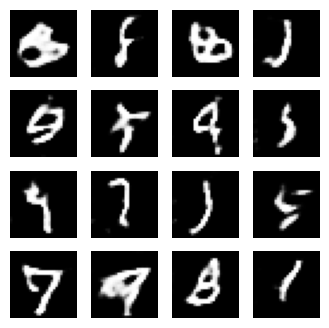

Tempo para processar época 1 foi de 99.74569797515869 segundos


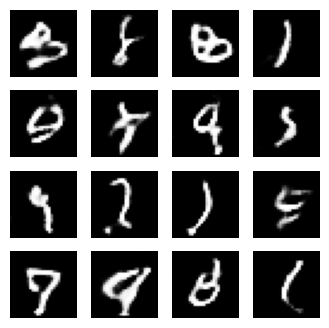

Tempo para processar época 2 foi de 99.77075934410095 segundos


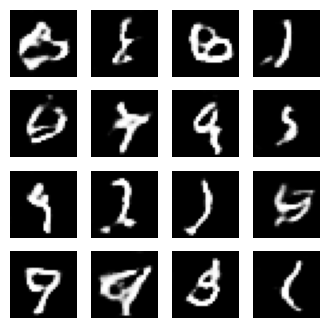

Tempo para processar época 3 foi de 100.26219749450684 segundos


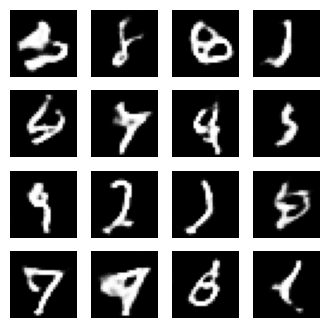

Tempo para processar época 4 foi de 100.67207860946655 segundos


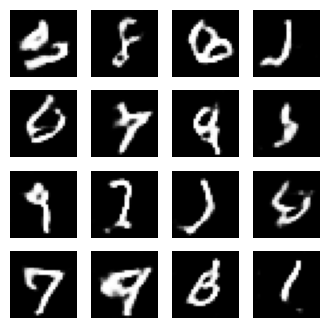

Tempo para processar época 5 foi de 102.65059018135071 segundos


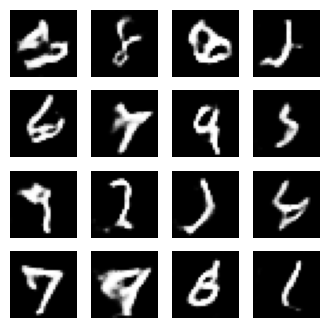

Tempo para processar época 6 foi de 142.61463832855225 segundos


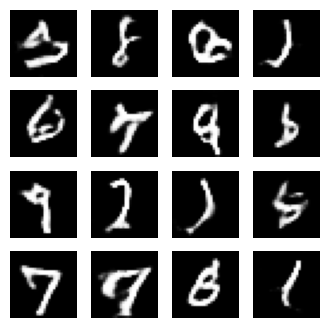

Tempo para processar época 7 foi de 99.64960861206055 segundos


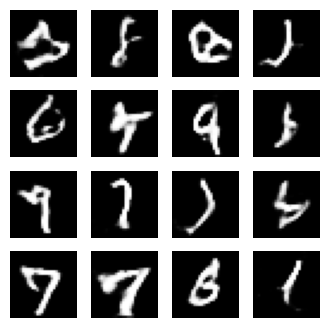

Tempo para processar época 8 foi de 99.62054347991943 segundos


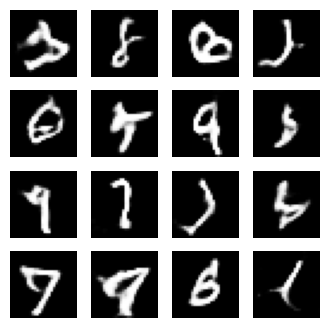

Tempo para processar época 9 foi de 99.31769943237305 segundos


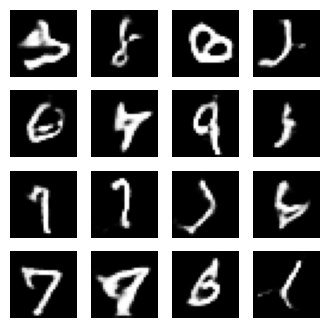

Tempo para processar época 10 foi de 99.3847005367279 segundos


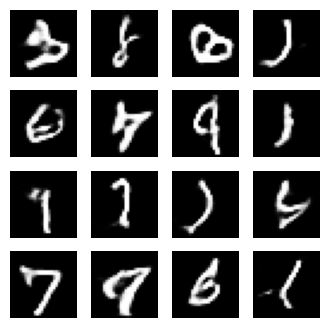

Tempo para processar época 11 foi de 99.41983461380005 segundos


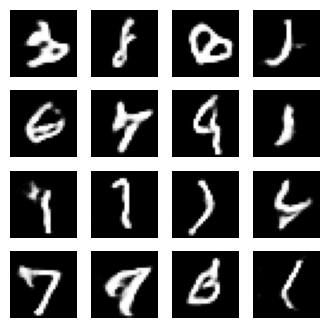

Tempo para processar época 12 foi de 99.49957919120789 segundos


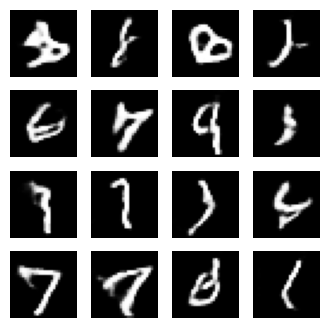

Tempo para processar época 13 foi de 142.27274656295776 segundos


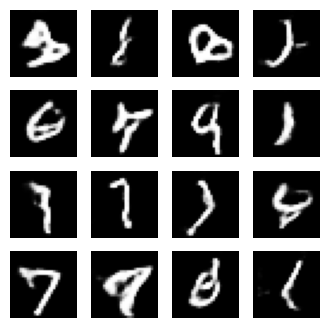

Tempo para processar época 14 foi de 99.59254050254822 segundos


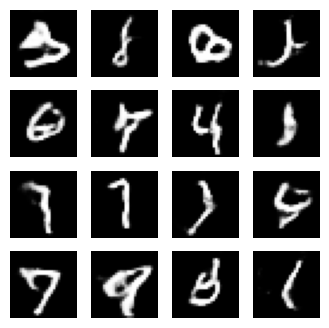

Tempo para processar época 15 foi de 99.13698983192444 segundos


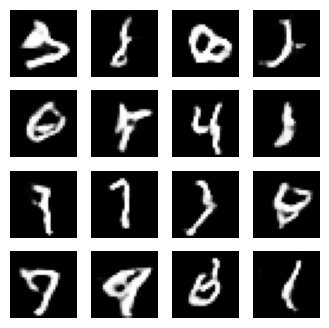

Tempo para processar época 16 foi de 98.72176909446716 segundos


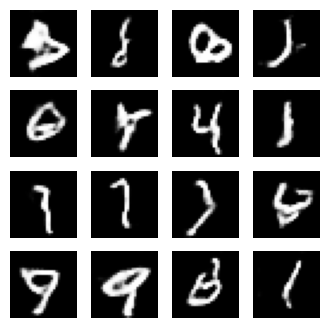

Tempo para processar época 17 foi de 99.08915257453918 segundos


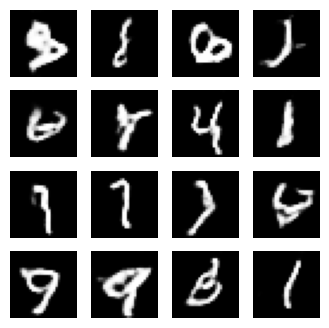

Tempo para processar época 18 foi de 98.88472580909729 segundos


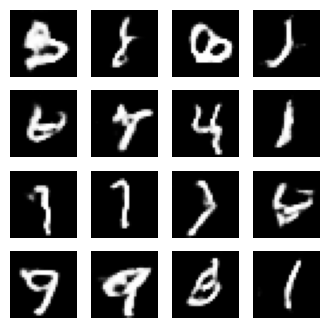

Tempo para processar época 19 foi de 98.75882482528687 segundos


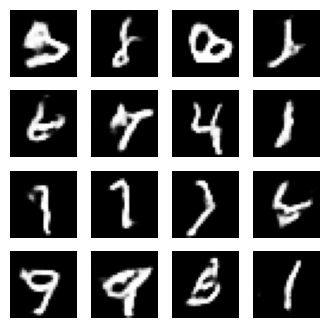

Tempo para processar época 20 foi de 99.16934704780579 segundos


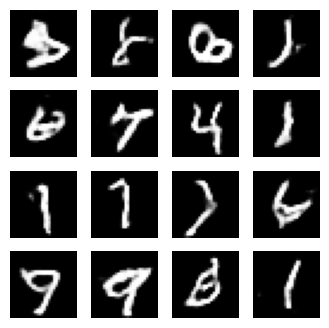

Tempo para processar época 21 foi de 99.31652426719666 segundos


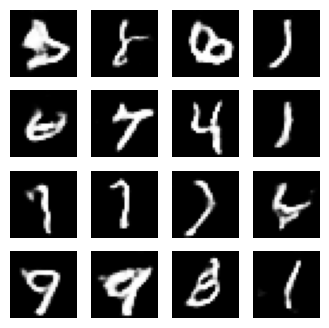

Tempo para processar época 22 foi de 99.73942494392395 segundos


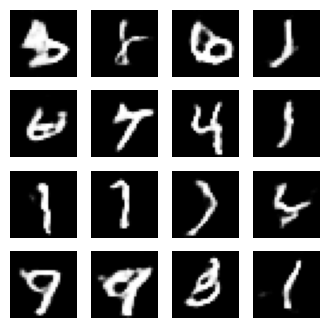

Tempo para processar época 23 foi de 99.59020042419434 segundos


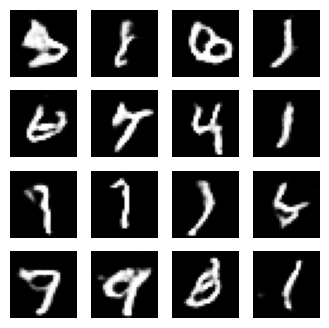

Tempo para processar época 24 foi de 100.04420757293701 segundos


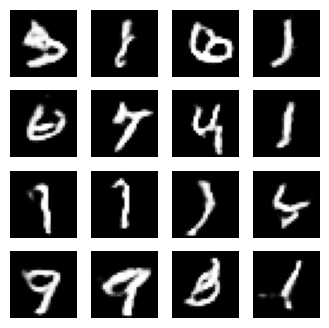

Tempo para processar época 25 foi de 142.28550004959106 segundos


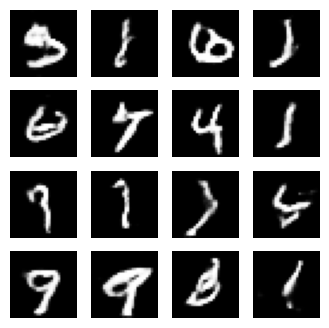

Tempo para processar época 26 foi de 100.23815894126892 segundos


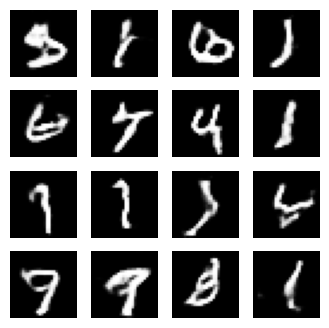

Tempo para processar época 27 foi de 99.03996253013611 segundos


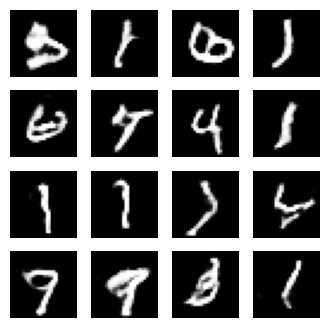

Tempo para processar época 28 foi de 100.16744542121887 segundos


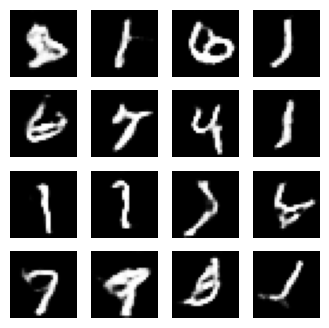

Tempo para processar época 29 foi de 100.59063291549683 segundos


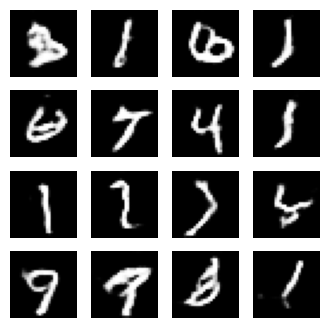

Tempo para processar época 30 foi de 99.45856499671936 segundos


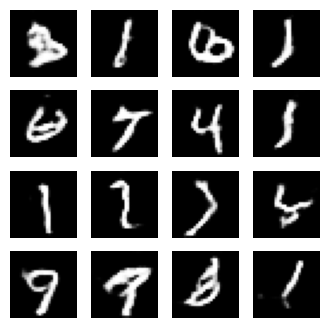

In [109]:
wgan_training(x_train, epochs)